# [Lecture 10 - Counts and Hidden Confounds](https://www.youtube.com/watch?v=jokxu18egu0)

In [1]:
%run init_notebook.py

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2023-09-02T14:05:14.150736-07:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 22.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

pandas     : 2.0.3
scipy      : 1.11.2
numpy      : 1.25.2
pymc       : 5.7.2
matplotlib : 3.7.1
arviz      : 0.16.1
xarray     : 2023.8.0
statsmodels: 0.14.0



# Revisiting Generalized Linear Models
- Expected value is **some function** of an additive combination of parameters
  - That function tends to be tied to the data Likelihood distribution -- e.g. Identity for the Normal distribution (linear regression) or the log odds for Bernoulli/Binomial distribution (logistic regression)
- Uniform changes in predictors are not generally associated with uniform changes in outcomes
- Predictor variables interact -- causal intererpretation of coefficients (outside of simplest models) is fraught with misleading conclusions

# Confounded Admissions

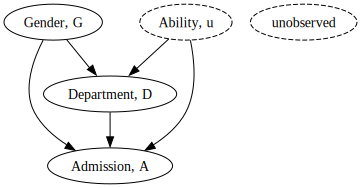

In [2]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "D"),
        ("G", "A"),
        ("D", "A"),
        ("u", "D"),
        ("u", "A")
    ],
    node_props={
        "u": {"style": "dashed", "label": "Ability, u"},
        "G": {"label": "Gender, G"},
        "D": {"label": "Department, D"},
        "A": {"label": "Admission, A"},
        "unobserved": {"style": "dashed"}
    }
)

- We estimated Direct and Total effect of Gender on Admission rates in order to identify different flavors of gender discrimination in admissions
- However, it's implausible that there are no uobserved confounds between variables,
  - e.g. Applicant ability could link Department to Admission rate
    - affects which students apply to each department (more ability biases department application)
    - also affect baseline admission rates (more ability leads to higher admission rates)

### Generative Simulation

In [3]:
np.random.seed(1)

# Number of applicants
n_samples = 2000

# Gender equally likely
G = np.random.choice([0, 1], size=n_samples, replace=True)

# Unobserved Ability -- 10% have High, everyone else is Average
u = stats.bernoulli.rvs(p=0.1, size=n_samples)

# Choice of department
# G0 applies to D0 with 75% probability else D1 with 1% or 0% based on ability
D = stats.bernoulli.rvs(p=np.where(G==0, u * 1.0, 0.75))

# Ability-based acceptance rates (ability x dept x gender)
p_u0_dg = np.array([[0.1, 0.1], [0.1, 0.3]])
p_u1_dg = np.array([[0.3, 0.5], [0.3, 0.5]])
p_udg = np.array([p_u0_dg, p_u1_dg])
print("Acceptance Probabilities\n(ability x dept x gender):\n\n", p_udg)

# Simulate acceptance
p = p_udg[u, D, G]
A = stats.bernoulli.rvs(p=p)

Acceptance Probabilities
(ability x dept x gender):

 [[[0.1 0.1]
  [0.1 0.3]]

 [[0.3 0.5]
  [0.3 0.5]]]


## Total Effect Estimator

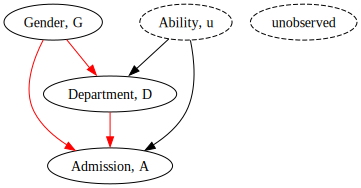

In [4]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "D"),
        ("G", "A"),
        ("D", "A"),
        ("u", "D"),
        ("u", "A")
    ],
    node_props={
        "u": {"style": "dashed", "label": "Ability, u"},
        "G": {"label": "Gender, G"},
        "D": {"label": "Department, D"},
        "A": {"label": "Admission, A"},
        "unobserved": {"style": "dashed"}
    },
    edge_props={
        ("G", "A"): {"color": "red"},
        ("G", "D"): {"color": "red"},
        ("D", "A"): {"color": "red"}
    }
)

- Estimating <span style="color:red">Total effect</span>  requires no adjustment set, model gender only in the GLM

$$
\begin{align*}
A_i &\sim \text{Bernoulli}(p=p_i) \\
\text{logit}(p_i) &= \alpha[G_i] \\
\alpha &= [\alpha_0, \alpha_1] \\
\alpha_j &\sim \text{Normal}(0, 1)
\end{align*}
$$

### Fit the Total Effect Model

In [5]:
# Define coordinates
GENDER_ID, GENDER = pd.factorize(["G2" if g else "G1" for g in G], sort=True)
DEPTARTMENT_ID, DEPARTMENT = pd.factorize(["D2" if d else "D1" for d in D], sort=True)

In [6]:
# Gender-only model
with pm.Model(coords={"gender": GENDER}) as total_effect_admissions_model:
    alpha = pm.Normal("alpha", 0, 1, dims='gender')
    
    # Likelihood
    p = pm.math.invlogit(alpha[GENDER_ID])
    pm.Bernoulli("admitted", p=p, observed=A)
    
    # Record the probability param for simpler reporting
    pm.Deterministic("p_admit", pm.math.invlogit(alpha), dims="gender")
    
    total_effect_admissions_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


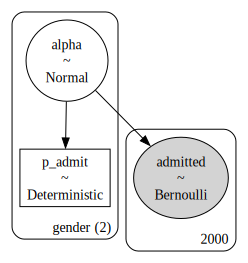

In [7]:
pm.model_to_graphviz(total_effect_admissions_model)

### Summarize the Total Effect Estimates

In [8]:
def summarize_posterior(inference, figsize=(5, 3)):
    """Helper function for displaying model fits"""
    _, axs = plt.subplots(2, 1, figsize=figsize)
    az.plot_forest(inference, var_names='alpha', combined=True, ax=axs[0])
    az.plot_forest(inference, var_names='p_admit', combined=True, ax=axs[1])
    return az.summary(inference, var_names=["alpha", "p_admit"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[G1],-1.995,0.097,-2.180,-1.820,0.002,0.001,4135.0,2413.0,1.0
alpha[G2],-1.094,0.075,-1.239,-0.956,0.001,0.001,4207.0,3131.0,1.0
p_admit[G1],0.120,0.010,0.101,0.139,0.000,0.000,4135.0,2413.0,1.0
p_admit[G2],0.251,0.014,0.225,0.278,0.000,0.000,4207.0,3131.0,1.0


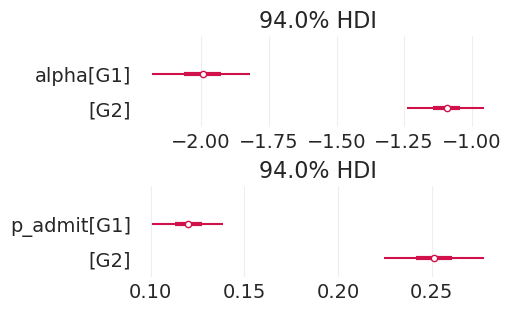

In [9]:
summarize_posterior(total_effect_admissions_inference)

## Direct Effect Estimator (now confounded due to common ability cause)

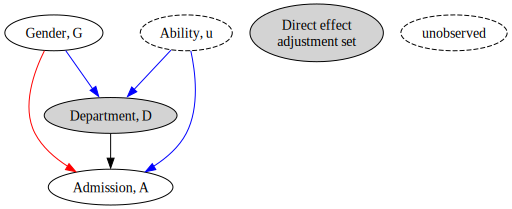

In [10]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "D"),
        ("G", "A"),
        ("D", "A"),
        ("u", "D"),
        ("u", "A")
    ],
    node_props={
        "u": {"style": "dashed", "label": "Ability, u"},
        "G": {"label": "Gender, G"},
        "D": {"label": "Department, D", "style": "filled"},
        "A": {"label": "Admission, A"},
        "Direct effect\nadjustment set": {"style": "filled"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("G", "A"): {"color": "red"},
        ("G", "D"): {"color": "blue"},
        ("u", "D"): {"color": "blue"},
        ("u", "A"): {"color": "blue"},
    }
)

- Estimating <span style="color:red">Direct effect</span> includes Department in the adjustment set
- However, stratifying by Department (collider)  <span style="color:blue">opens a confounder backdoor path </span> through unobserved ability, u

$$
\begin{align*}
A_i &\sim \text{Bernoulli}(p=p_i) \\
\text{logit}(p_i) &= \alpha_{[D_i, G_i]} \\
\alpha &= \begin{bmatrix} \alpha_{0,0}, \alpha_{0,1} \\  \alpha_{1,0}, \alpha_{1,1} \end{bmatrix} \\
\alpha_{j,k} &\sim \text{Normal}(0, 1)
\end{align*}
$$

### Fit the (confounded) Direct Effect Model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


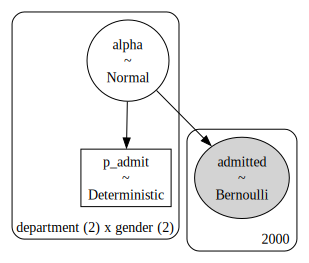

In [11]:
with pm.Model(coords={"gender": GENDER, "department": DEPARTMENT}) as direct_effect_admissions_model:
    # Prior
    alpha = pm.Normal("alpha", 0, 1, dims=["department", "gender"])
    
    # Likelihood
    p = pm.math.invlogit(alpha[DEPTARTMENT_ID, GENDER_ID])
    pm.Bernoulli("admitted", p=p, observed=A)
    
    # Record the acceptance probability parameter for reporting
    pm.Deterministic("p_admit", pm.math.invlogit(alpha), dims=["department", "gender"])
    
    direct_effect_admissions_inference = pm.sample(tune=2000)

pm.model_to_graphviz(direct_effect_admissions_model)

### Summarize the (confounded) Direct Effect Estimates

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[D1, G1]",-2.150,0.107,-2.342,-1.943,0.001,0.001,6152.0,3360.0,1.0
"alpha[D1, G2]",-1.539,0.171,-1.870,-1.231,0.002,0.001,6904.0,3044.0,1.0
"alpha[D2, G1]",-0.988,0.216,-1.388,-0.595,0.003,0.002,7273.0,3727.0,1.0
"alpha[D2, G2]",-0.955,0.081,-1.103,-0.798,0.001,0.001,6458.0,3331.0,1.0
"p_admit[D1, G1]",0.105,0.010,0.085,0.122,0.000,0.000,6152.0,3360.0,1.0
"p_admit[D1, G2]",0.178,0.025,0.133,0.225,0.000,0.000,6904.0,3044.0,1.0
"p_admit[D2, G1]",0.273,0.042,0.196,0.351,0.000,0.000,7273.0,3727.0,1.0
"p_admit[D2, G2]",0.278,0.016,0.249,0.310,0.000,0.000,6458.0,3331.0,1.0


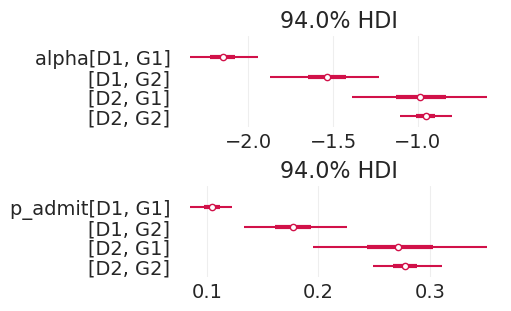

In [12]:
summarize_posterior(direct_effect_admissions_inference)

### Interpreting the (confounded) Direct Effect Estimates

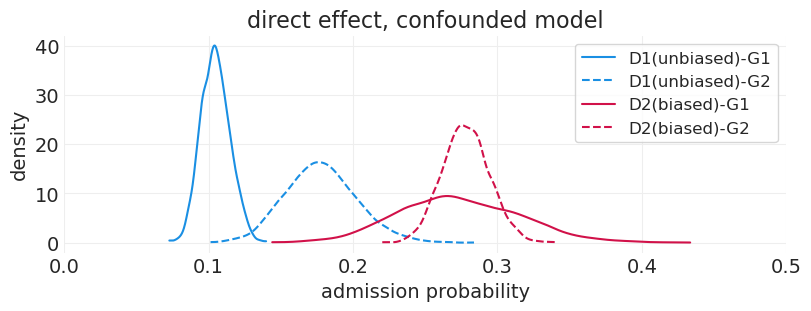

In [13]:
def plot_department_gender_admissions(inference, title):
    plt.subplots(figsize=(8, 3))
    for ii, dept in enumerate(["D1", "D2"]):
        for jj, gend in enumerate(["G1", "G2"]):
            # note inverse link function applied
            post = inference.posterior
            post_p_accept = post.sel(department=dept, gender=gend)['p_admit']
            label=f'{dept}({"biased" if ii else "unbiased"})-G{jj+1}'
            color=f'C{np.abs(ii - 1)}'  # flip colorscale to match lecture
            linestyle= '--' if jj else "-"
            az.plot_dist(
                post_p_accept,
                color=color,
                label=label,
                plot_kwargs=dict(linestyle=linestyle),
            )
    plt.xlim([0, .5])
    plt.xlabel("admission probability")
    plt.ylabel("density")
    plt.title(title);
    
plot_department_gender_admissions(direct_effect_admissions_inference, 'direct effect, confounded model')

#### Interpreting the Confounded Direct Effect Model
- In D1, G1 appears to be disatvantaged, with a lower admission rate. However, we know this isn't true. What's happening is that all the higher-ability G1 applicants are being sent to D2, thus artificially lowering the G1 acceptance rate in D1
- We know that there is bias in D2, however, we see little evidence for discrimination. This is due to higher-ability G1 applicatins ofsetting this bias by having higher-than-average acceptance
- We can see that G1 estimates for D2 have higher variance; this is due to there being only 10% of applicants having high ability, thus fewer G1 applicants overall apply to D2.

#### You guessed it: Collider Bias
- **This is due to _collider bias_**
  - stratifying by Department--which forms a colider with Gender and ability--opens a path through the ability to acceptance.
  - **You CANNOT estimate _Direct effect_ of $D$ on $G$**
  - **You CAN estimate the _Total effect_**
- **sorting can mask or accentuate bias**


## Analogous Example: NAS Membership & Citations

Two papers
- same data
- find drastically different conclusions about Gender and its effect on admission to the National Academy of Sciences (NAS)
  - One found Women are strongly advantaged
  - The other found woemen strongly disadvantaged
- How can both conclusions be true?

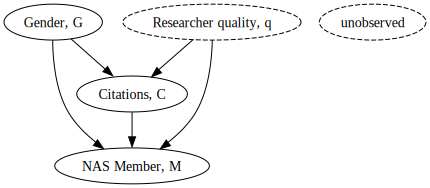

In [14]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "C"),
        ("G", "M"),
        ("C", "M"),
        ("q", "C"),
        ("q", "M")
    ],
    node_props={
        "q": {"style": "dashed", "label": "Researcher quality, q"},
        "G": {"label": "Gender, G"},
        "C": {"label": "Citations, C"},
        "M": {"label": "NAS Member, M"},
        "unobserved": {"style": "dashed"},
    }
)

- There are likely latent Researcher quality difference
- Stratifying by number of citations opens up a collider bias with unobserved Researcher quality
  Citations is a **post-treatment variable**
- Citation-stratification provide misleading conclusions
- e.g. if there is discrimination in publication/citation, one gender may get elected at a higher rate just because they will have higher quality on on average for any citation level

### No Causes in, no causes out

These papers suffere from a number of shortcomings

- vague estimands
- unwise adjustment sets
- requires stronger assumptions than presented
- collider bias could affect policy design in a bad way
- qualitative data can be useful in these circumstances


## Sensitivity Analysis: Modeling latent ability confound variable

**What are the implications of things we can't measure?**

Similar to Direct Effect scenario

- Estimatinge <span style="color:red">Direct effect</span> includes Department in the adjustment set
- However, stratifying by Department (collider)  <span style="color:blue">opens a confounder backdoor path </span> through unobserved ability, u

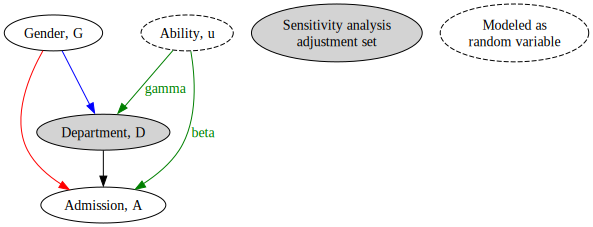

In [15]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "D"),
        ("G", "A"),
        ("D", "A"),
        ("u", "D"),
        ("u", "A")
    ],
    node_props={
        "u": {"label": "Ability, u", "style": "dashed"},
        "G": {"label": "Gender, G",},
        "D": {"label": "Department, D", "style": "filled"},
        "A": {"label": "Admission, A"},
        "Sensitivity analysis\nadjustment set": {"style": "filled"},
        "Modeled as\nrandom variable": {"style": "dashed"},
    },
    edge_props={
        ("G", "A"): {"color": "red"},
        ("G", "D"): {"color": "blue"},
        ("u", "D"): {"color": "green", "label": "gamma", "fontcolor": "green"},
        ("u", "A"): {"color": "green", "label": "beta", "fontcolor": "green"},
    }
)

Though we can't directly measure a potential confound, what we can do is _simulate_ the degree of the effect of a potential confound. Specifically, we can set up a simulation where we create a random variable associated with the potential confound, then weight the amount of contribution that confound has on generating the observed data.

In this particular example, we can simulate the degree of effect of an ability random variable $U \sim \text{Normal}(0, 1)$, by adding a linearly weighted contribution of that variable to the log odds of Acceptance and selecting a department (this is because we u affect both D and A in our causal graph):

#### Department submodel
$$
\begin{align*}
D_i &\sim \text{Bernouilli}(q_i) \\
logit(q_i) &= \delta[G_i] + \gamma_{G[i]}  u_i \\
\delta[G_i] &\sim \text{Normal}(0, 1) \\
u_j &\sim \text{Normal}(0, 1)
\end{align*}
$$

#### Acceptance submodel
$$
\begin{align*}
A_i &\sim \text{Bernouilli}(p_i) \\
logit(p_i) &= \alpha[G_i, D_i] + \beta_{G[i]} u_i \\
\alpha[G_i, D_i] &\sim \text{Normal}(0, 1) \\
u_j &\sim \text{Normal}(0, 1)
\end{align*}
$$

Where we <span style="color:green"> **manually set the value of $\beta_{G[i]}$ and $\gamma_{G[i]}$ by hand</span>  to perform the simulation**

### Fit the latent ability model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u, delta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


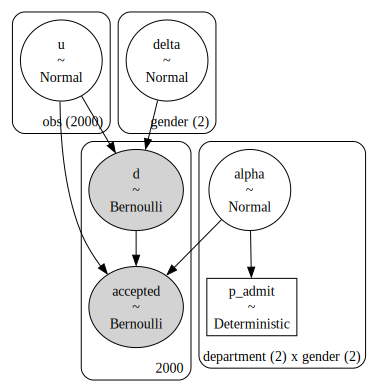

In [16]:
# Gender-specific counterfactual parameters
# Ability confound affects admission rates equally for genders
BETA = np.array([1., 1.])

# Ability confound affects department application differentially
# for genders (as is the case in generative data process)
GAMMA = np.array([1., 0.])

coords = {"gender": GENDER, "department": DEPARTMENT, "obs": np.arange(n_samples)}

with pm.Model(coords=coords) as latent_ability_model:
    
    # Latent ability variable, one for each applicant
    U = pm.Normal("u", 0, 1, dims="obs")
    
    # Department application submodel
    delta = pm.Normal('delta', 0, 1, dims='gender')
    q = pm.math.invlogit(delta[GENDER_ID] + GAMMA[GENDER_ID] * U)

    selected_department = pm.Bernoulli('d', p=q, observed=D)
    
    # Acceptance submodel
    alpha = pm.Normal("alpha", 0, 1, dims=["department", "gender"])
    p = pm.math.invlogit(alpha[GENDER_ID, selected_department] + BETA[GENDER_ID] * U)
    pm.Bernoulli('accepted', p=p, observed=A)
    
    # Record p(A | D, G) for reporting
    p_admit = pm.Deterministic("p_admit", pm.math.invlogit(alpha), dims=['department', 'gender'])
    
    latent_ability_inference = pm.sample()
    
pm.model_to_graphviz(latent_ability_model)

### Summarize the latent ability estimate

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[D1, G1]",-2.388,0.117,-2.594,-2.141,0.002,0.001,5412.0,2722.0,1.0
"alpha[D1, G2]",-1.912,0.255,-2.379,-1.429,0.003,0.002,5500.0,2743.0,1.0
"alpha[D2, G1]",-1.805,0.191,-2.157,-1.441,0.003,0.002,5445.0,3059.0,1.0
"alpha[D2, G2]",-1.142,0.096,-1.323,-0.958,0.001,0.001,6059.0,3062.0,1.0
"p_admit[D1, G1]",0.085,0.009,0.067,0.103,0.000,0.000,5412.0,2722.0,1.0
"p_admit[D1, G2]",0.131,0.029,0.080,0.186,0.000,0.000,5500.0,2743.0,1.0
"p_admit[D2, G1]",0.143,0.023,0.097,0.184,0.000,0.000,5445.0,3059.0,1.0
"p_admit[D2, G2]",0.242,0.018,0.207,0.273,0.000,0.000,6059.0,3062.0,1.0


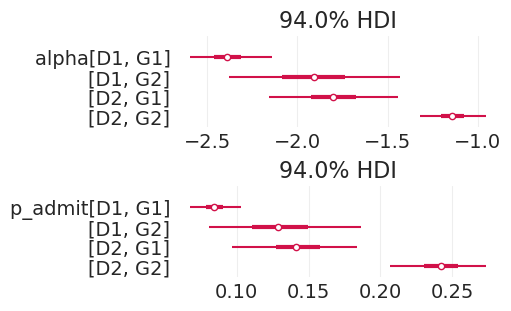

In [17]:
summarize_posterior(latent_ability_inference)

### Interpreting the Effect of modeling the confound

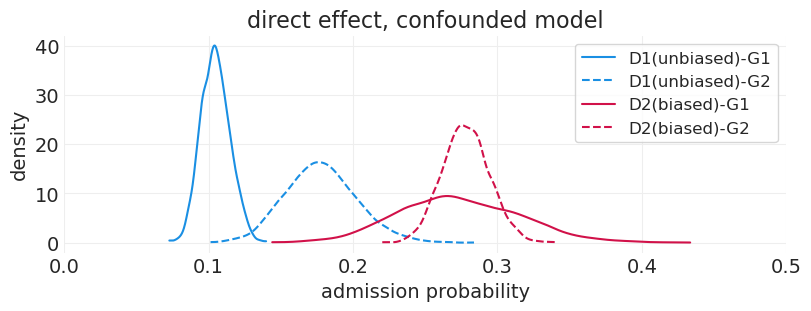

In [18]:
plot_department_gender_admissions(direct_effect_admissions_inference, 'direct effect, confounded model')

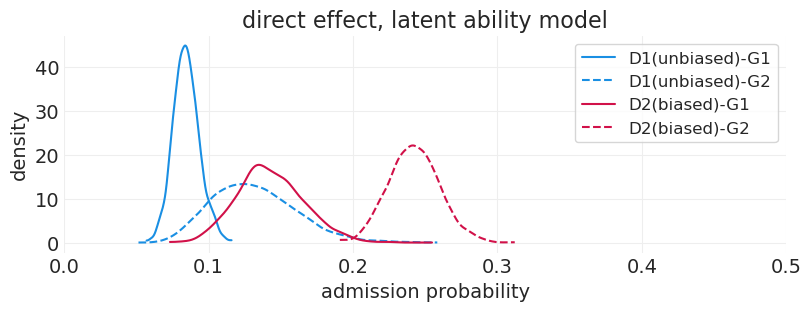

In [19]:
plot_department_gender_admissions(latent_ability_inference, "direct effect, latent ability model")

By adding sensitivity analysis that is aligned with the data-generating process, we are able to identify gender bias in department 2

## Review of Sensitivity Analysis
- Confounds exist, event if we can't measure them directly -- don't simply pretend that they don't exist
- Address the question: **What are the implications of what we _don't know_?**
- SA is somewhere between simulation and analysis
  - Hard-coding what we don't know, and let the rest play out.
  - Vary the confound over a range (e.g. std deviations) and show how that change effects the estimate
- More honest than pretending that confounds do not exist.

## Note on number of parameters 🤯
- Sensitivity Analysis model has 2006 free parameters
- Only 2000 observations
- No biggie in Bayesian Analysis
  - The minimum sample size is 0, where we just fall back on the prior

# Counts and Poisson Regression

## Kline & Boyd Oceanic Technology Dataset

How is technological complexity in a society related to population size?

**Estimand**: Influence of **population size** and **contact** on **total tools**

In [20]:
# Load the data
KLINE = utils.load_data("Kline")
KLINE

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


## Conceptual Ideas
- The more innnovation the more tools
- The more people, the more innovation
- The more contact between cultures, the more innovation
- Innovations (tools) are also forgotten over time, or become obsolete

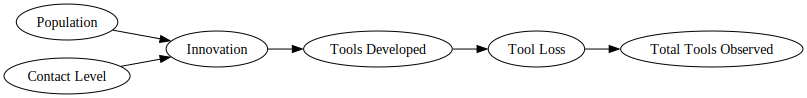

In [21]:
utils.draw_causal_graph(
    edge_list=[
        ("Population", "Innovation"),
        ("Innovation", "Tools Developed"),
        ("Contact Level", "Innovation"),
        ("Tools Developed", "Tool Loss"),
        ("Tool Loss", "Total Tools Observed")
    ],
    graph_direction="LR"
)

### Scientific Model

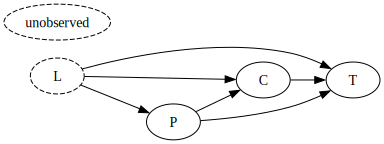

In [22]:
utils.draw_causal_graph(
    edge_list=[
        ("C", "T"),
        ("L", "T"),
        ("L", "P"),
        ("L", "C"),
        ("P", "C"),
        ("P", "T")
    ],
    node_props={
        "L": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    },
    graph_direction="LR"
)

- Poplulation is treatment
- Tools is outcome
- Contact level moderates effect of Population (Pipe)
- Location is unobserved confound
  - better materials
  - proximity to other cultures
  - can support larger populations
  - _we'll ignore for now_
 

Adjustment set for **Direct effect of Population on Tools**
  - Location, if it were observed
  - Also stratify by contact to study interactions

## Modeling total tools
- There's no upper limit on tools --> can't use Binomial
- **Poisson Distribution** approaches Binomial for large $N$ (approaching infinity) and low $p$ (approching 0)

### Poisson GLM

$$
\begin{align*}
Y_i &\sim \text{Poisson}(\lambda_i) \\
\log(\lambda_i) &= \alpha + \beta x_i
\end{align*}
$$

- link function is $\log(\lambda)$
- inverse link function is $\exp(\alpha + \beta x_i)$
- strictly positive $\lambda$ (due to exponential)


### Poisson Priors

- **Be careful with Exponential scaling, it can give shocking results!** Usually long tails result
- Easier to shift the location (e.g. a the mean of a Normal prior), and keep tight variances
- Prior variances generally need to be quite tight, on the order of 0.1 - 0.5


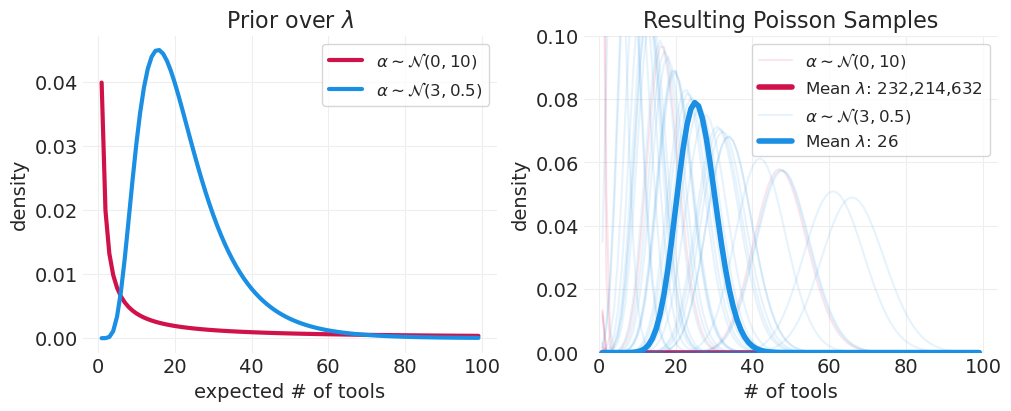

In [23]:
np.random.seed(123)
num_tools = np.arange(1, 100)
_, axs = plt.subplots(1, 2, figsize=(10, 4))

plt.sca(axs[0])

normal_alpha_prior_params = [
    (0, 10),  # flat, centered prior
    (3, .5)   # offset, tight prior
]

for prior_mu, prior_sigma in normal_alpha_prior_params:
    # since log(lambda) = alpha, if
    # alpha is Normally distributed, therefore lambda is log-normal
    lambda_prior_dist = stats.lognorm(s=prior_sigma, scale=np.exp(prior_mu))
    label=f"$\\alpha \sim \mathcal{{N}}{prior_mu, prior_sigma}$"
    pdf = lambda_prior_dist.pdf(num_tools)
    plt.plot(num_tools, pdf, label=label, linewidth=3)
    
plt.xlabel("expected # of tools")
plt.ylabel("density")
plt.legend()
plt.title("Prior over $\\lambda$")

plt.sca(axs[1])

n_prior_samples = 30
for ii, (prior_mu, prior_sigma) in enumerate(normal_alpha_prior_params):
    
    # Sample lambdas from the prior
    prior_dist = stats.norm(prior_mu, prior_sigma)
    alphas = prior_dist.rvs(n_prior_samples)
    lambdas = np.exp(alphas)
    mean_lambda = lambdas.mean()

    for sample_idx, lambda_ in enumerate(lambdas):        
        pmf = stats.poisson(lambda_).pmf(num_tools)
        
        label=f"$\\alpha \sim \mathcal{{N}}{prior_mu, prior_sigma}$" if sample_idx == 1 else None
        color=f"C{ii}"
        plt.plot(num_tools, pmf, color=color, label=label, alpha=.1)
        
    mean_lambda_ = np.exp(alphas).mean()
    pmf = stats.poisson(mean_lambda_).pmf(num_tools)
    plt.plot(num_tools, pmf, color=color, label=f"Mean $\\lambda$: {mean_lambda:1,.0f}", alpha=1, linewidth=4)
    
plt.xlabel("# of tools")
plt.ylabel("density")
plt.ylim([0, .1])
plt.legend()
plt.title("Resulting Poisson Samples");

### Adding a Slope to the mix $\log(\lambda_i) = \alpha + \beta x_i$

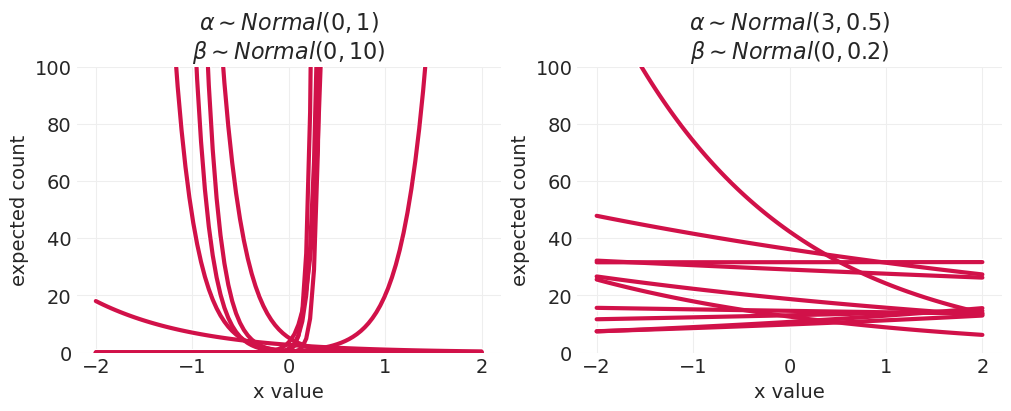

In [24]:
np.random.seed(123)
normal_alpha_prior_params = [
    (0, 1),  # flat, centered prior
    (3, .5)   # offset, tight prior
]

normal_beta_prior_params = [
    (0, 10),  # flat, centered prior
    (0, .2)   # tight, centered
]

n_prior_samples = 10
_, axs = plt.subplots(1, 2, figsize=(10, 4))
xs = np.linspace(-2, 2, 100)[:, None]
for ii, (a_params, b_params) in enumerate(zip(normal_alpha_prior_params, normal_beta_prior_params)):
    plt.sca(axs[ii])
    alpha_prior_samples = stats.norm(*a_params).rvs(n_prior_samples)
    beta_prior_samples = stats.norm(*b_params).rvs(n_prior_samples)
    lambda_samples = np.exp(alpha_prior_samples + xs * beta_prior_samples)
    
    utils.plot_line(xs, lambda_samples, label=None, color='C0')
    plt.ylim([0, 100])
    plt.title(f"$\\alpha \\sim Normal{a_params}$\n$\\beta \\sim Normal{b_params}$")
    plt.xlabel("x value")
    plt.ylabel("expected count")

Expected Count functions drawn from two different types of priors
- Left: wide priors
- Right: tight priors

## Direct Effect Estimator

- Estimatinge <span style="color:red">Direct effect of population P on number of tools T</span> includes contact level, C in the adjustment set and location, L (currently unobserved; we will ignore for now)

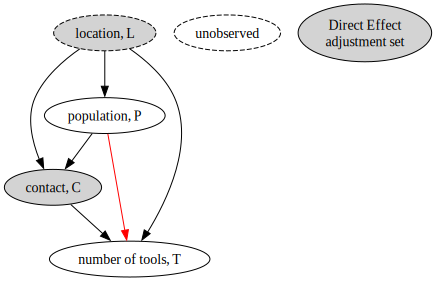

In [25]:
utils.draw_causal_graph(
    edge_list=[
        ("L", "C"),
        ("P", "C"),
        ("C", "T"),
        ("L", "T"),
        ("L", "P"),
        ("P", "T")
    ],
    node_props={
        "L": {"label": "location, L", "style": "dashed,filled"},
        "C": {"label": "contact, C", "style": "filled"},
        "P": {"label": "population, P"},
        "T": {"label": "number of tools, T"},
        "unobserved": {"style": "dashed"},
        "Direct Effect\nadjustment set": {"style": "filled"}
    },
    edge_props={
        ("P", "T"): {"color": "red"}
    }
)

## Comparing Models

We'll estimate a couple of models in order to practice model comparison
- Model A) A simple, global intercept Poisson GLM
- Model B) A Poisson GLM that includes intercept and parameter for the standardized log-population, both of which are stratified by contact level

### Model A - Global Intercept model
Here we model tools count as a Poisson random variable. The poisson rate parameter is the exponent of a linear model. In this linear model, we include only an offset for low- or high- contact populations.

$$
\begin{align*}
T_i &\sim \text{Poisson}(\lambda_i) \\
\lambda_i &= \alpha_{C[i]} \\
\alpha &\sim \text{Normal}(3, 0.5) \\
\end{align*}
$$

In [26]:
# Set up data and coords
TOOLS = KLINE.total_tools.values.astype(float)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


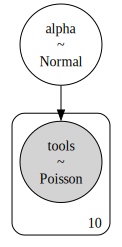

In [27]:
with pm.Model() as global_intercept_model:
    
    # Prior on global intercept
    alpha = pm.Normal('alpha', 3.0, .5)
    
    # Likelihood
    lam = pm.math.exp(alpha)
    pm.Poisson("tools", lam, observed=TOOLS)
    
    global_intercept_inference = pm.sample()
    global_intercept_inference = pm.compute_log_likelihood(global_intercept_inference)
    
pm.model_to_graphviz(global_intercept_model)

### Model B  - Interaction model

Here we bracket both the intercept and the population regression coefficient by contact level

$$
\begin{align*}
T_i &\sim \text{Poisson}(\lambda_i) \\
\lambda_i &= \alpha_{C[i]} + \beta_{C[i]} \log(P) \\
\alpha &\sim \text{Normal}(3, 0.5) \\
\beta &\sim \text{Normal}(0, 0.2) \\
\end{align*}
$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


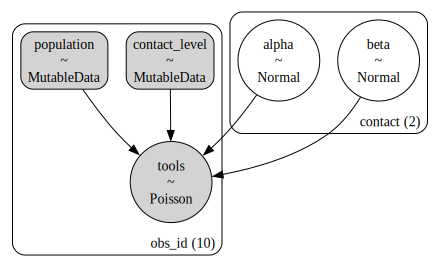

In [28]:
# contact-level
CONTACT_LEVEL, CONTACT = pd.factorize(KLINE.contact)

# Standardized log population
POPULATION = KLINE.population.values.astype(float)
STD_LOG_POPULATION = utils.standardize(np.log(POPULATION))
N_CULTURES = len(KLINE)
OBS_ID = np.arange(N_CULTURES).astype(int)

with pm.Model(coords={"contact": CONTACT}) as interaction_model:
    
    # Set up mutable data for predictions
    std_log_population = pm.MutableData("population", STD_LOG_POPULATION, dims="obs_id")
    contact_level = pm.MutableData("contact_level", CONTACT_LEVEL, dims="obs_id")
    
    # Priors
    alpha = pm.Normal("alpha", 3, .5, dims="contact")  # intercept
    beta = pm.Normal("beta", 0, .2, dims="contact")    # linear interaction with std(log(Population))
    
    # Likelihood
    lamb = pm.math.exp(alpha[contact_level] + beta[contact_level] * std_log_population)
    pm.Poisson("tools", lamb, observed=TOOLS, dims="obs_id")
    
    interaction_inference = pm.sample()

    # NOTE: For compute_log_likelihood to work for models that contain variables
    # with dims but no coords (e.g. dims="obs_ids"), we need the
    # following PR to be merged https://github.com/pymc-devs/pymc/pull/6882
    # (I've implemented the fix locally to get notebooks to execute)
    # TODO: Once merged, update pymc version in conda environment yaml
    interaction_inference = pm.compute_log_likelihood(interaction_inference)

pm.model_to_graphviz(interaction_model)

### Model Comparisons

In [29]:
# Compare the intercept-only and interation models
compare_dict = {
    'global intercept': global_intercept_inference,
    'interaction': interaction_inference
}
az.compare(compare_dict)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
interaction,0,-42.586601,7.000529,0.000000,0.946453,6.218410,0.000000,True,log
global intercept,1,-70.639027,8.119301,28.052426,0.053547,15.971869,15.714973,False,log


> pPSIS discussed in the lecture is analogous to `p_loo` in the output above

### Posterior Predictions

In [30]:
def plot_tools_model_posterior_predictive(model, inference, title, input_natural_scale=False, plot_natural_scale=True, resolution=100):

    # Set up population grid based on model input scale
    if input_natural_scale:
        ppd_population_grid = np.linspace(0, np.max(POPULATION) * 1.05, resolution)

    # input is standardized log scale
    else:
        ppd_population_grid = np.linspace(
            STD_LOG_POPULATION.min() * 1.05,
            STD_LOG_POPULATION.max() * 1.05,
            resolution
        )

    # Set up contact-level counterfactuals
    with model:
        # Predictions for low contact
        pm.set_data(
            {
                'contact_level':np.array([0] * resolution),
                'population': ppd_population_grid
            }
        )

        low_contact_ppd = pm.sample_posterior_predictive(
            inference,
            var_names=["tools"],
            predictions=True
        )["predictions"]["tools"]

        # Predictions for high contact
        pm.set_data(
            {
                'contact_level':np.array([1] * resolution),
                'population': ppd_population_grid
            }
        )
        
        hi_contact_ppd = pm.sample_posterior_predictive(
            inference,
            var_names=["tools"],
            predictions=True
        )["predictions"]["tools"]

        low_contact_ppd_mean = low_contact_ppd.mean(["chain", "draw"])
        hi_contact_ppd_mean = hi_contact_ppd.mean(["chain", "draw"])
        
        colors = ["C0" if c else "C1" for c in CONTACT_LEVEL]
        
        # Set up visualization scale
        if plot_natural_scale:
            if input_natural_scale:
                population_grid = ppd_population_grid
            else:
                population_grid = np.exp(ppd_population_grid * np.log(POPULATION).std() + np.log(POPULATION).mean())
                
            scatter_population = POPULATION
            xlabel = 'population'
        # visualize in log scale
        else:
            if input_natural_scale:
                population_grid = np.log(ppd_population_grid)
            else:
                population_grid = ppd_population_grid

            scatter_population = STD_LOG_POPULATION
            xlabel = 'population (standardized log)'
            
        marker_size = 50 + 400 * POPULATION / POPULATION.max()
        utils.plot_scatter(xs=scatter_population, ys=TOOLS, color=colors, s=marker_size, facecolors=None, alpha=1)
            
        # low-contact posterior predictive
        az.plot_hdi(
            x=population_grid,
            y=low_contact_ppd, color="C1",
            hdi_prob=.89,
            fill_kwargs={"alpha": 0.2}
        )
        plt.plot(population_grid, low_contact_ppd_mean, color="C1", label='low contact')

        # high-contact posterior predictive
        az.plot_hdi(
            x=population_grid,
            y=hi_contact_ppd,
            color="C0",
            hdi_prob=.89,
            fill_kwargs={"alpha": 0.2}
        )
        plt.plot(population_grid, hi_contact_ppd_mean, color="C0", label='hi contact')
        plt.legend()

        plt.xlabel(xlabel)
        plt.ylabel('total tools');
        plt.title(title);

Sampling: [tools]


Sampling: [tools]


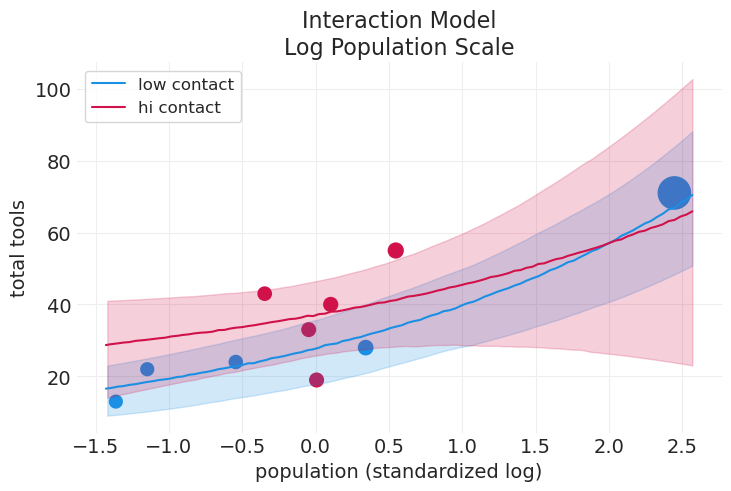

In [31]:
plot_tools_model_posterior_predictive(
    interaction_model,
    interaction_inference,
    title="Interaction Model\nLog Population Scale",
    plot_natural_scale=False
)

Sampling: [tools]


Sampling: [tools]


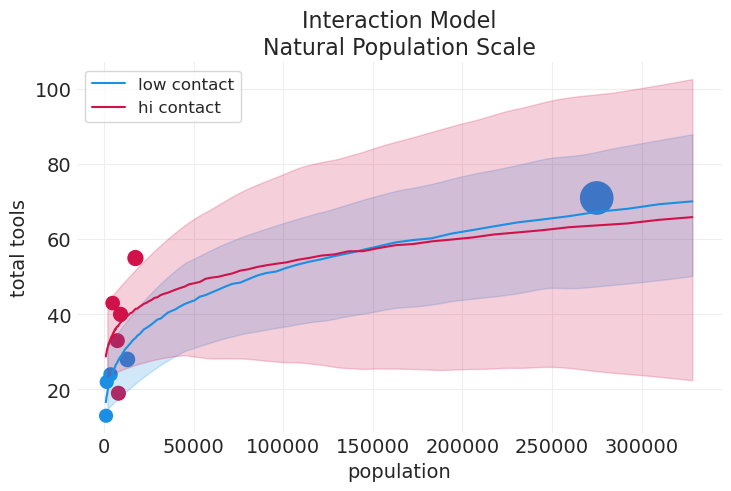

In [32]:
plot_tools_model_posterior_predictive(
    interaction_model,
    interaction_inference,
    title="Interaction Model\nNatural Population Scale",
    plot_natural_scale=True
)

### The model above is "wack" for the following reasons:

1. The low-contact mean intersects with the high-contact mean (around population of 150k). This makes little since logically
2. The intercept for population = 0 should be very near 0. It's instead around 20 and 30 for both groups.
3. Tonga isn't even included in the 89% HDI for the hi contact group
4. Error for hi-contact group is absurdly large for a majority of the population range

Can we do better?

## Improving the estimator with a better scientific model

There are two immediate to improve the model, including:

1. Robust regression model -- in this case a gamma-Poisson (neg-binomial) model
2. **Use a more prinicipled scientific model**

## Scientific model that includes innovation and technology loss
Recall from earlier this DAG that highlights the general conceptual idea of how observeed tools can arise:

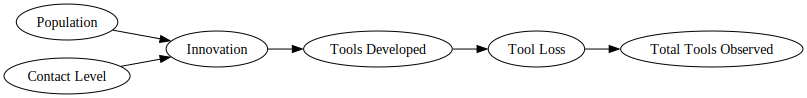

In [33]:
utils.draw_causal_graph(
    edge_list=[
        ("Population", "Innovation"),
        ("Innovation", "Tools Developed"),
        ("Contact Level", "Innovation"),
        ("Tools Developed", "Tool Loss"),
        ("Tool Loss", "Total Tools Observed")
    ],
    graph_direction="LR"
)

**Why not develope a sicentific model that does just that?**

### Using the difference equation: $\Delta T = \alpha P^\beta - \gamma T$

- $\Delta T$ is the change in # of tools given the current number of tools. Here T can be thought of as # of tools at current generation
- $\alpha$ is the innovation rate for a population of size $P$
- $\beta$ is the elasticity, and can be thought of as a saturation rate, or "diminishing returns" factor; if we constrain $0 > \beta < 1$ 
- $\gamma$ is the attritions / technology loss rate at time T

Furthermore we can parameterize such an equation by the class of contact rate, $C$ as $\Delta T = \alpha_C P^{\beta_C} - \gamma T$

Now we leverage the notioin of **equilibrium** identify the steady state # of tools that are eventually obtained. At this point $\Delta T = 0$, and we can solve for the resulting $\hat T$ using algebra: 


$$
\begin{align*}
\Delta T &= \alpha P^\beta - \gamma \hat T = 0 \\
\gamma \hat T &= \alpha P^\beta\\
\hat T &= \frac{\alpha_C P^{\beta_C}}{\gamma}
\end{align*}
$$


### Simulate the difference equation for various societies

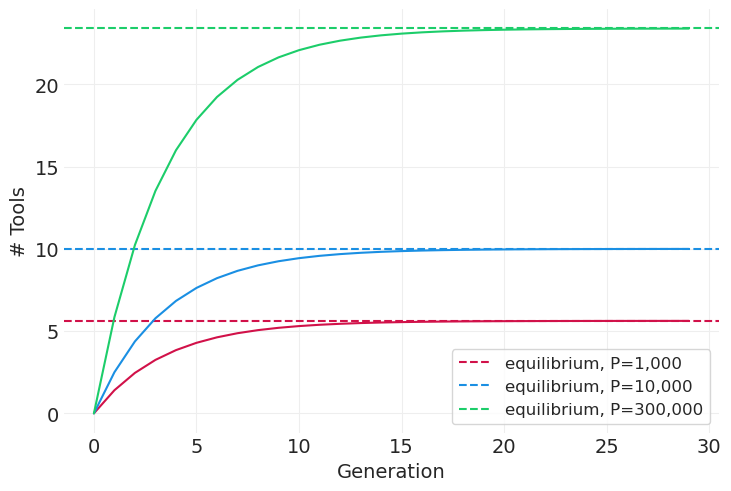

In [34]:
def simulate_tools(alpha=.25, beta=.25, P=1e3, gamma=.25, n_generations=30, color='C0'):
    """Simulate the Tools data as additive difference process equilibrium condition"""
    def difference_equation(t):
        return  alpha * P ** beta - gamma * t
    
    # Run the simulation
    tools = [0]
    generations = range(n_generations)
    for g in generations:
        t = tools[-1]
        tools.append(t + difference_equation(t))
    
    t_equilibrium = (alpha * P ** beta) / gamma
    
    # Plot it
    plt.plot(generations, tools[:-1], color=color)
    plt.axhline(
        t_equilibrium,
        color=color,
        linestyle='--',
        label=f'equilibrium, P={int(P):,}'
    )
    plt.legend()
    
simulate_tools(P=1e3, color='C0')
simulate_tools(P=1e4, color='C1');
simulate_tools(P=300_000, color='C2');
plt.xlabel("Generation")
plt.ylabel("# Tools");

### Innovation / Loss Statistical Model
- Use $\hat T = \lambda$ as the expected number of tools, i.e. $T \sim \text{Poisson}(\hat T)$
- **Note**: we must constrain $\lambda$ to be positive, which we can do in a couple of ways:
  1. Exponentiate variables
  2. Use appropriate priors that constrain the variables to be positive (we'll use this approach)

$$
\begin{align*}
T &\sim \text{Poisson}(\hat T_i) \\
\hat T_i &= \frac{\alpha_{C[i]} P^{\beta_{C[i]}}}{\gamma} \\
\alpha_j, \beta_j, \gamma &\sim \text{Exponential}(\eta)
\end{align*}
$$

### Determine good prior hyperparams
We'll use an Exponential distribution as a prior on the difference equation parameters $\alpha, \beta, \gamma$. We thus need to identify a good rate hypoerparmeter $\eta$ for those priors.

Reasonable values for all parameters were were approximately 0.25 in the simulation above. We would thus like to identify the the Exponential rate parameter that covers 0.25 = 1/4.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 21 seconds.


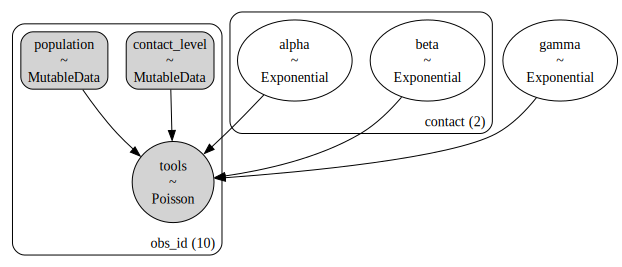

In [35]:
ETA = 4
with pm.Model(coords={"contact": CONTACT}) as innovation_loss_model:
    
    # Note: raw population here, not log/standardized
    population = pm.MutableData("population", POPULATION, dims="obs_id")
    contact_level = pm.MutableData("contact_level", CONTACT_LEVEL, dims="obs_id")
    
    # Priors -- we use Exponential for all.
    # Note that in the lecture: McElreath uses a Normal for alpha
    # then applies a exp(alpha) to enforce positive contact-level
    # innovation rate
    alpha = pm.Exponential("alpha", ETA, dims="contact")
    
    # contact-level elasticity
    beta = pm.Exponential("beta", ETA, dims="contact")
    
    # global technology loss rate
    gamma = pm.Exponential("gamma", ETA)
    
    # Likelihood using difference equation equilibrium as mean Poisson rate
    T_hat = (alpha[contact_level] * (population ** beta[contact_level])) / gamma
    pm.Poisson("tools", T_hat, observed=TOOLS, dims="obs_id")

    innovation_loss_inference = pm.sample(tune=2000, target_accept=.98)
    # NOTE: For compute_log_likelihood to work for models that contain variables
    # with dims but no coords (e.g. dims="obs_ids"), we need the
    # following PR to be merged https://github.com/pymc-devs/pymc/pull/6882
    # (I've implemented the fix locally to get notebooks to execute)
    # TODO: Once merged, update pymc version in conda environment yaml
    innovation_loss_inference = pm.compute_log_likelihood(innovation_loss_inference)
    

pm.model_to_graphviz(innovation_loss_model)

In [36]:
az.summary(innovation_loss_inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[low],0.308,0.227,0.019,0.725,0.006,0.004,1231.0,1103.0,1.0
alpha[high],0.323,0.261,0.006,0.764,0.006,0.004,1661.0,1712.0,1.0
beta[low],0.261,0.033,0.196,0.320,0.001,0.001,1900.0,1565.0,1.0
beta[high],0.293,0.107,0.098,0.497,0.003,0.002,1135.0,949.0,1.0
gamma,0.119,0.093,0.005,0.279,0.002,0.002,1163.0,1195.0,1.0


We can see that for the $\alpha$ and $\beta$ parameters, the optimal value was around 0.23-0.28. For gamma, it was a bit smaller, at around 0.09. We could potentially re-parameterize our model to have a tigher prior for the Gamma variable, but meh.

### Posterior predictions

In [37]:
#### Replot the contact model for comparison

Sampling: [tools]


Sampling: [tools]


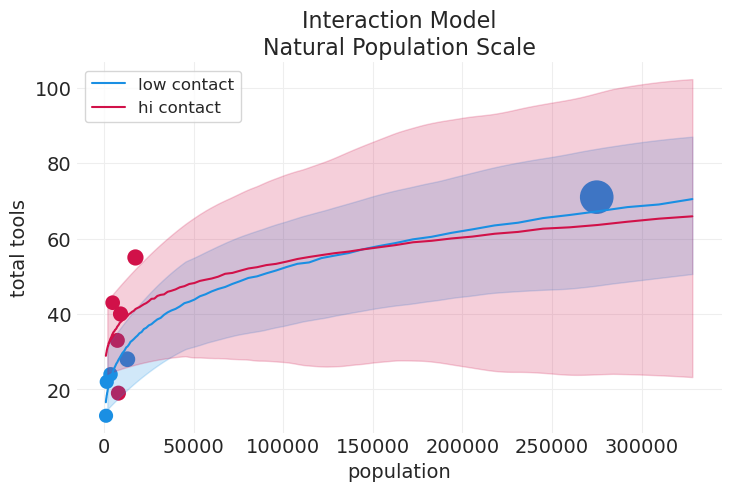

In [38]:
plot_tools_model_posterior_predictive(
    interaction_model,
    interaction_inference,
    title="Interaction Model\nNatural Population Scale",
    plot_natural_scale=True
)

Sampling: [tools]


Sampling: [tools]


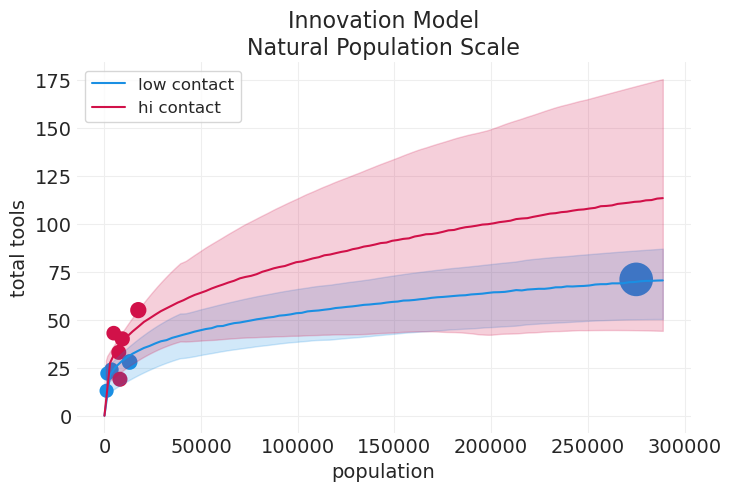

In [39]:
plot_tools_model_posterior_predictive(
    innovation_loss_model,
    innovation_loss_inference,
    title="Innovation Model\nNatural Population Scale",
    input_natural_scale=True,
    plot_natural_scale=True
)

Notice the following improvements over the basic interaction model
- No weird crossover of low/high contact trends
- zero population now associated with zero tools

### Model Comparisons

In [40]:
compare_dict = {
    'global intercept': global_intercept_inference,
    'contact': interaction_inference,
    'innovation loss' : innovation_loss_inference
}
az.compare(compare_dict)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
innovation loss,0,-40.661071,5.534656,0.000000,8.743829e-01,5.678648,0.000000,True,log
contact,1,-42.586601,7.000529,1.925530,5.567797e-16,6.218410,2.472354,True,log
global intercept,2,-70.639027,8.119301,29.977956,1.256171e-01,15.971869,16.522944,False,log


We can also see that the innovation / loss model is far superior (weight=.94) in terms of LOO prediction.

### Take-homes
- Generally best to have a domain-informed scientific model
- We still have the unobserved location confound to deal with

# Review: Count GLMS
- MaxEnt priors
  - Binomal
  - Poisson & Extensions
  - `log` link function; `exp` inverse link function

  
- Robust Regression
  - Beta-Binomial
  - Gamma-Poisson

# BONUS: Simpons's Pandora's Box

**The reversal of some measured/estimated association when groups are either combined or separated.**

- There is nothing particularly interesting or Paradoxical about Simpson's paradox
- It is simply a statistical phenomena
- There are any number of causal phenoena that can create SP
  - Pipes and Forks can cause one flavor of SP -- namely stratifying destroys trend / associations
  - Collider can cause the inverse flavor -- nameley stratifying ellicits a trend / association
- You can't say one way or the other which direction of "reversal" is correct without making explicit causal claims

### Classic example is UC Berkeley Admissions
- If you do not stratify/condition on Department, you find that Females are Admitted at a lower rate
- If you stratify/condition on Department, you find that Females are Admitted at a slightly higher rate (see above Admissions analyses)
- Which is correct? Could be explained by either:
  - a mediator/pipe (department)
  - a collider + confound (unobserved ability)
  
**For examples of how Pipes, Forks, and Colliders can "lead to" Simpson's paradox, see Leture 05 -- Elemental Confounds notes**


## Nonlinear Haunting

Though $Z$ is not a confound, it is an competing cause of $Y$. If the causal model is nonlinear and we stratify by $Z$ to get the direct causa effect of the treatment on the outcome, this can cause some strange outcomes akin to Simpson's paradox.


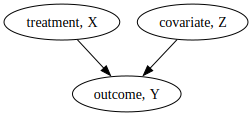

In [41]:
utils.draw_causal_graph(
    edge_list=[
        ("treatment, X", "outcome, Y"),
        ("covariate, Z", "outcome, Y")
    ]
)

### Example: Base Rate Differences

Here we simulate data where $X$ and $Z$ are independent, but $Z$ has a nonlinear causal effect on $Y$

#### Generative Simulation

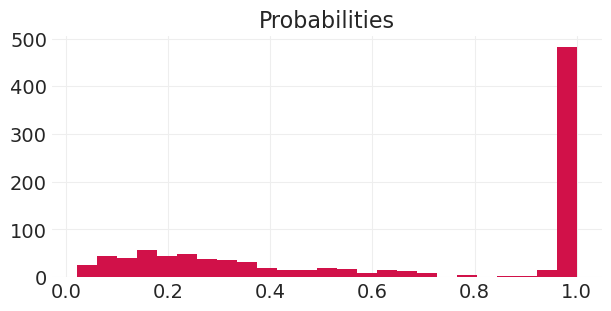

In [42]:
np.random.seed(123)
n_simulations = 1000

X = stats.norm.rvs(size=n_simulations)
Z = stats.bernoulli.rvs(p=.5, size=n_simulations)

# encode a nonlinear effect of Z on Y
BETA_XY = 1
BETA_Z0Y = 5
BETA_Z1Y = -1

p = utils.invlogit(X * BETA_XY + np.where(Z, BETA_Z1Y, BETA_Z0Y))
Y = stats.bernoulli.rvs(p=p)

plt.subplots(figsize=(6, 3))
plt.hist(p, bins=25);
plt.title("Probabilities");

### Unstratified Model -- $\text{logit}(p_i) = \alpha + \beta X_i$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


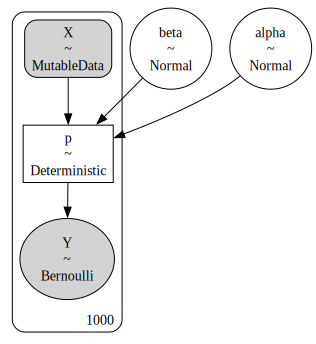

In [43]:
# Unstratified model
with pm.Model() as unstratified_model:
    
    # MutableData for PPDs
    x = pm.MutableData("X", X)
    
    # Global params
    alpha = pm.Normal("alpha", 0, 1)
    beta = pm.Normal("beta", 0, 1)
    
    # record p for plotting predictions
    p = pm.Deterministic("p", pm.math.invlogit(alpha + beta * x))
    pm.Bernoulli("Y", p=p, observed=Y)
    
    unstratified_inference = pm.sample()
    
pm.model_to_graphviz(unstratified_model)

### Partially Stratified Model -- $\text{logit}(p) = \alpha + \beta_{Z[i]} X_i$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


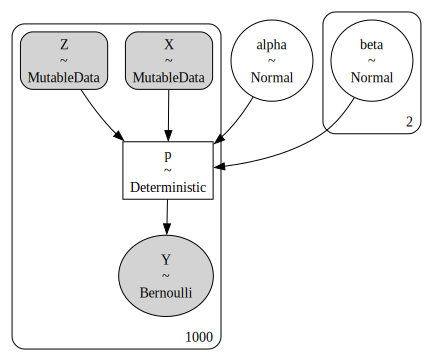

In [44]:
# Partially statified Model
with pm.Model() as partially_stratified_model:
    
    # Mutable data for PPDs
    x = pm.MutableData("X", X)
    z = pm.MutableData("Z", Z)
    
    alpha = pm.Normal("alpha", 0, 1)
    beta = pm.Normal("beta", 0, 1, shape=2)
    
    # record p for plotting predictions
    p = pm.Deterministic("p", pm.math.invlogit(alpha + beta[z] * x))
    pm.Bernoulli("Y", p=p, observed=Y)
    
    partially_stratified_inference = pm.sample()

    
pm.model_to_graphviz(partially_stratified_model)

### Unstratified model posterior predictions

In [45]:
# Get predictions -- unstratified model
RESOLUTION = 100
xs = np.linspace(-3, 3, RESOLUTION)

with unstratified_model:
    pm.set_data({'X':xs})
    unstratified_ppd = pm.sample_posterior_predictive(
        unstratified_inference,
        var_names=["p"]
    )["posterior_predictive"]["p"]

Sampling: []


### Partially Stratified model posterior predictions

In [46]:
# Get predictions -- partially stratified model
partially_stratified_predictions = {}
with partially_stratified_model:
    for z in [0, 1]:
        # Z = 0 predictions
        pm.set_data({'X':xs})
        pm.set_data({'Z':[z] * RESOLUTION})
        partially_stratified_predictions[z] = pm.sample_posterior_predictive(
            partially_stratified_inference,
            var_names=["p"]
        )["posterior_predictive"]["p"]

Sampling: []


Sampling: []


### Plot the effect of stratification

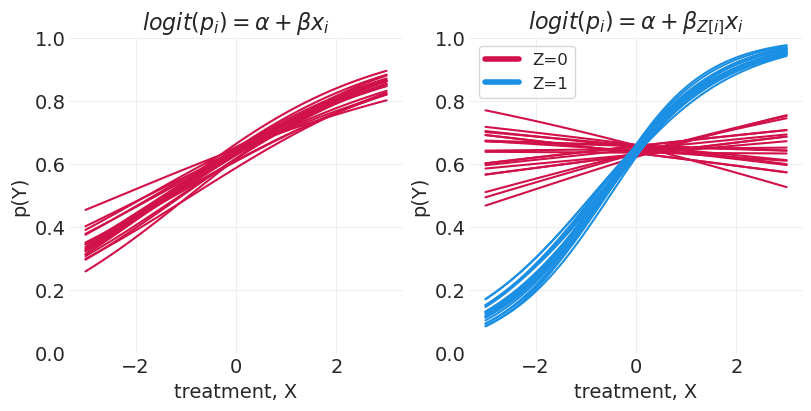

In [47]:
from matplotlib.lines import Line2D

n_posterior_samples = 20
_, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.sca(axs[0])

# Plot predictions -- unstratified model
plt.plot(xs, unstratified_ppd.sel(chain=0)[:n_posterior_samples].T, color='C0');
plt.xlabel("treatment, X")
plt.ylabel("p(Y)")
plt.ylim([0, 1])
plt.title("$logit(p_i) = \\alpha + \\beta x_i$");

# For tagging conditions in legend
legend_data = [
    Line2D([0], [0], color="C0", lw=4),
    Line2D([0], [0], color="C1", lw=4),
]


plt.sca(axs[1])
for z in [0, 1]:
    ys = partially_stratified_predictions[z].sel(chain=0)[:n_posterior_samples].T
    plt.plot(xs,ys, color=f'C{z}', label=f"Z={z}");

plt.xlabel("treatment, X")
plt.ylabel("p(Y)")
plt.ylim([0, 1])

plt.legend(legend_data, ['Z=0', 'Z=1'])

plt.title("$logit(p_i) = \\alpha + \\beta_{Z[i]}x_i$");

plt.sca(axs[0])

When stratifying only on the X coefficient, and thus sharing a common intercept, we can see that for Z=0, there is a saturation around 0.6. This is due to the +5 added to the log odds of Y|Z=0 in the logistic regression model. Because of this saturation, it's difficult to tell if the treatment affects the outcome for that group.

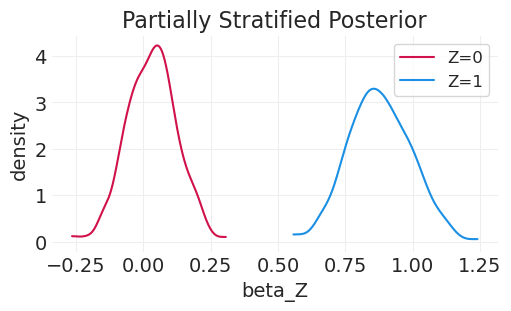

In [48]:
_, axs = plt.subplots(figsize=(5, 3))
for z in [0, 1]:
    post = partially_stratified_inference.posterior.sel(chain=0)['beta'][:, z]
    az.plot_dist(post, color=f"C{z}", label=f'Z={z}')
plt.xlabel("beta_Z")
plt.ylabel("density")
plt.legend()
plt.title("Partially Stratified Posterior");

### Try a fully-stratified model -- $\text{logit}(p_i) = \alpha_{Z[i]} + \beta_{Z[i]}X_i$

Include a separate intercept for each group

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


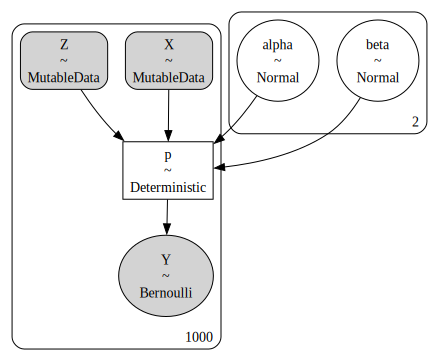

In [49]:
# Fully statified Model
with pm.Model() as fully_stratified_model:
    
    x = pm.MutableData("X", X)
    z = pm.MutableData("Z", Z)
    
    # Stratify intercept by Z as well
    alpha = pm.Normal("alpha", 0, 1, shape=2)
    beta = pm.Normal("beta", 0, 1, shape=2)
    
    # Log p for plotting predictions
    p = pm.Deterministic('p', pm.math.invlogit(alpha[z] + beta[z] * x))
    pm.Bernoulli("Y", p=p, observed=Y)
    fully_stratified_inference = pm.sample()

    
pm.model_to_graphviz(fully_stratified_model)

### Fullly Stratified Model posterior predictions

In [50]:
# Get predictions -- partially stratified model
fully_stratified_predictions = {}
with fully_stratified_model:
    for z in [0, 1]:
        # Z = 0 predictions
        pm.set_data({'X': xs})
        pm.set_data({'Z': [z] * RESOLUTION})
        fully_stratified_predictions[z] = pm.sample_posterior_predictive(
            fully_stratified_inference,
            var_names=["p"]
        )["posterior_predictive"]["p"]

Sampling: []


Sampling: []


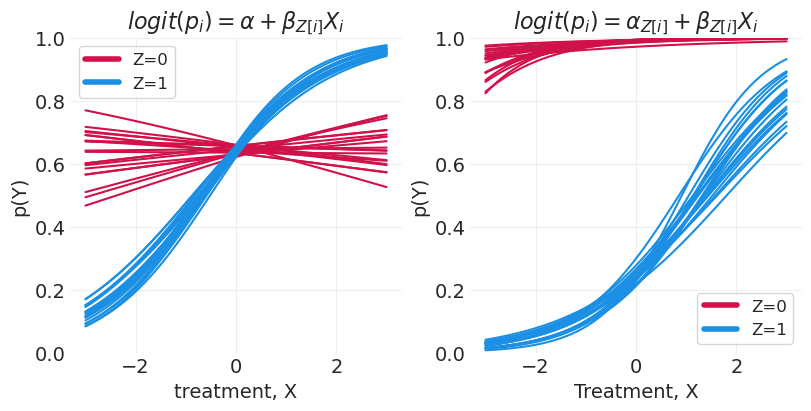

In [51]:
n_posterior_samples = 20
_, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.sca(axs[0])

for z in [0, 1]:
    ys = partially_stratified_predictions[z].sel(chain=0)[:n_posterior_samples].T
    plt.plot(xs,ys, color=f'C{z}', label=f"Z={z}");

plt.xlabel("treatment, X")
plt.ylabel("p(Y)")
plt.ylim([0, 1])

plt.legend(legend_data, ['Z=0', 'Z=1'])
plt.title("$logit(p_i) = \\alpha + \\beta_{Z[i]}X_i$");

plt.sca(axs[1])
for z in [0, 1]:
    ys = fully_stratified_predictions[z].sel(chain=0)[:n_posterior_samples].T
    plt.plot(xs,ys, color=f'C{z}', label=f"Z={z}");

plt.xlabel("Treatment, X")
plt.ylabel("p(Y)")
plt.ylim([0, 1])

plt.legend(legend_data, ['Z=0', 'Z=1'])

plt.title("$logit(p_i) = \\alpha_{Z[i]} + \\beta_{Z[i]}X_i$");

Here we can see that with a fully stratified model, one in which we include a group-level intercept, the predicitions for Z=0 shift up even higher toward one, though the predictions remain mostly flat across all values of the treatment X

### Compare Posteriors

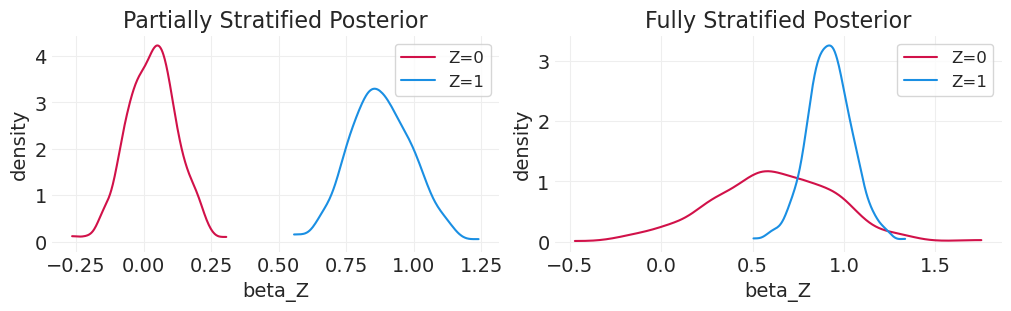

In [52]:
_, axs = plt.subplots(1, 2, figsize=(10, 3))

plt.sca(axs[0])

for z in [0, 1]:
    post = partially_stratified_inference.posterior.sel(chain=0)['beta'][:, z]
    az.plot_dist(post, color=f"C{z}", label=f'Z={z}')
plt.xlabel("beta_Z")
plt.ylabel("density")
plt.legend()
plt.title("Partially Stratified Posterior");


plt.sca(axs[1])
for z in [0, 1]:
    post = fully_stratified_inference.posterior.sel(chain=0)['beta'][:, z]
    az.plot_dist(post, color=f"C{z}", label=f'Z={z}')
plt.xlabel("beta_Z")
plt.ylabel("density")
plt.legend()
plt.title("Fully Stratified Posterior");

## Simpson's Paradox Summary
- No paradox, almost anything can produce SP
- Coefficient reversals have little interpretive value outside of causal framework
- **Don't focus on coefficients: push predictions through model to compare**
- Random note: you can't accept the NULL, you can only reject it.
  - Just because a distribution overlaps 0 doesn't mean it's zero
